## Сразу сделаем функцию для отображения вероятностей правдоподобия


In [18]:
import matplotlib.pyplot as plt

def plot_lists(lists, names, lw=1, figsize=(8,6)):
    # Устанавливаем фон серым
    plt.style.use('ggplot')
    plt.figure(figsize=figsize)
    # Разные цвета для каждого списка
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

    # Отрисовываем графики для каждого списка
    for i, lst in enumerate(lists):
        plt.plot(range(len(lst)), lst, color=colors[i % len(colors)], label=names[i], lw=lw)
    plt.ylabel('Log Probability')
    plt.xlabel('Intergene interval')
    # Добавляем сетку
    plt.grid(True)

    # Добавляем легенду
    plt.legend()

    # Показываем график
    plt.show()

from sys import argv

inf = open(argv[1], "r")
genes = list()
iniflag = False
seqflag = False
exset = set()
for line in inf:
  if seqflag and len(line) > 70:
    sequence += line[5:70].replace(" ", "")
  else:
    if line.startswith("SQ   "):
      sequence = ""
      seqflag = True
    else:
      if line.startswith("FT   source"):
        length = int(line.strip().split("..")[1])
      if line.startswith("FT   gene            "):
        if "join" not in line and ("<" not in line) and (">" not in line):
          if "complement" in line:
            (s, e) = tuple(line.rstrip("\n)")[32:].split(".."))
            r = True
          else:
            (s, e) = tuple(line[21:].split(".."))
            r= False
          start = int(s)
          end = int(e)
          if start < end:
            genes.append((start, end, r))
          else:
            iniflag = True
            inistart = start
            genes.append((0, end))
        else:
          exset.add(len(genes) - 1)
inf.close()
if iniflag:
  genes.append((inistart, length))

intergenes = list()
if (not iniflag) and (genes[0][0] > 20) and (-1 not in exset):
  intergenes.append((1, genes[0][0] - 1))
for i in range(len(genes) - 1):
  if (genes[i+1][0] - genes[i][1] > 20) and (i not in exset):
    intergenes.append((genes[i][1] + 1, genes[i+1][0] - 1))
if (not iniflag) and (length - genes[-1][1] > 20) and (len(genes) - 1 not in exset):
  intergenes.append((genes[-1][1] + 1, length))
print(len(intergenes))
print(len(sequence))

try:
  outf = open(argv[2], "w")
except Exception:
  outf = open("intergenes.fasta", "w")
for i in range(len(intergenes)):
  start = intergenes[i][0]
  end = intergenes[i][1]
  outf.write(">intergene{} {} {}\n".format(i+1, start, end))
  outf.write(sequence[start-1:end] + '\n')
outf.close()

In [19]:
!wget https://www.ebi.ac.uk/ena/browser/api/embl/AE000520.1 -O AE000520.1.embl # скачиваем геном

--2024-04-17 16:25:33--  https://www.ebi.ac.uk/ena/browser/api/embl/AE000520.1
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [text/plain]
Saving to: ‘AE000520.1.embl’

AE000520.1.embl         [              <=>   ]   2.83M   613KB/s    in 5.2s    

2024-04-17 16:25:39 (555 KB/s) - ‘AE000520.1.embl’ saved [2965429]



In [20]:
!python script.py AE000520.1.embl # применяем скрипт (я руками создал файл script.py в колабе и туда ваш код сохранил)

635
1138011


In [21]:
# нехитрим способом делим все выборку пополам на валид и тест
train_list = []
valid_list = []
with open('intergenes.fasta', 'r') as ptr:
  ctr = 0
  for line in ptr:
    if '>' in line:
      continue

    if ctr % 2 == 0:
      train_list.append(line.strip())
    else:
      valid_list.append(line.strip())
    ctr += 1

In [22]:
print(f'Lenth of train list {len(train_list)}\nLength of valid list {len(valid_list)}')

Lenth of train list 318
Length of valid list 317


In [23]:
train_join = ''.join(train_list) # конкатенируем все межгенные промежутки тренировочного датасета для обучения 4 моделей

# bernulli

In [24]:
# считаем вхождение каждой буквы в тренировочной датасет
a_count = train_join.count('a')
t_count = train_join.count('t')
g_count = train_join.count('g')
c_count = train_join.count('c')

train_len = a_count + t_count + g_count + c_count
# проверяем нет ли нестандартных нуклеотидов
assert train_len == len(train_join), 'Error: exist undefineble element'

AssertionError: Error: exist undefineble element

# ищем какие нуклеотиды нетсандартные, если их мало то просто удалим и все

In [25]:
for i in train_join:
  if i != 'a' and i != 't' and i != 'g' and i != 'c':
    print(i)

y


In [26]:
ind = train_join.index('y')
train_join = train_join[:ind] + train_join[ind+1:] # удаляем этот элемент из тренировочного датасета
assert train_len == len(train_join), 'Error: exist undefineble element'

In [27]:
# обучаемся
import numpy as np
from scipy.special import logsumexp
# делим количество каждой буквы на размер датасета и переводим в лог шкалу, получая по сути параметры модели бернулли
p_a = np.log(a_count/train_len)
p_t = np.log(t_count/train_len)
p_g = np.log(g_count/train_len)
p_c = np.log(c_count/train_len)

# проверка на то что сумма равна 1
assert logsumexp([p_a, p_t, p_g, p_c]) == 0, 'Error: probability space error'

# Перед получением правдоподобия на валидации надо проверить есть ли нетипичные нуклеотиды в вал сете, если их мало то удалим для упрощения:

In [28]:
for intergene in range(len(valid_list)):
  for nucleotide in range(len(valid_list[intergene])):
    if valid_list[intergene][nucleotide] != 'a' and valid_list[intergene][nucleotide] != 't' and valid_list[intergene][nucleotide] != 'g' and valid_list[intergene][nucleotide] != 'c':
      print(f'Founded atipical nucleotide [{valid_list[intergene][nucleotide]}] in {intergene} intergene and {nucleotide} position')

Founded atipical nucleotide [r] in 32 intergene and 83 position
Founded atipical nucleotide [s] in 47 intergene and 119 position
Founded atipical nucleotide [s] in 146 intergene and 47 position
Founded atipical nucleotide [s] in 146 intergene and 50 position
Founded atipical nucleotide [s] in 174 intergene and 34 position


In [29]:
deleted = valid_list[32][83]
valid_list[32] = valid_list[32][:83] + valid_list[32][84:]
print(f'Atipical nucleotide [{deleted}] was deleted')
deleted = valid_list[47][119]
valid_list[47] = valid_list[47][:119] + valid_list[47][120:]
print(f'Atipical nucleotide [{deleted}] was deleted')
deleted = valid_list[146][47]
valid_list[146] = valid_list[146][:47] + valid_list[146][48:]
print(f'Atipical nucleotide [{deleted}] was deleted')
deleted = valid_list[146][49]
valid_list[146] = valid_list[146][:49] + valid_list[146][50:] # тут надо аккуратно, тк мы удалили уже элемент из этого межгенного промежутка, так что индекс будет не 50 а 49
print(f'Atipical nucleotide [{deleted}] was deleted')
deleted = valid_list[174][34]
valid_list[174] = valid_list[174][:34] + valid_list[174][35:]
print(f'Atipical nucleotide [{deleted}] was deleted')

Atipical nucleotide [r] was deleted
Atipical nucleotide [s] was deleted
Atipical nucleotide [s] was deleted
Atipical nucleotide [s] was deleted
Atipical nucleotide [s] was deleted


In [30]:
# считаем правдоподобие для каждого межгенного промежутка в валидации:
prob_bernulli = [0] * len(valid_list)

for intergene in range(len(valid_list)):
  for nucleotide in valid_list[intergene]:
    if nucleotide == 'a':
      prob_bernulli[intergene] += p_a
    if nucleotide == 't':
      prob_bernulli[intergene] += p_t
    if nucleotide == 'g':
      prob_bernulli[intergene] += p_g
    else:
      prob_bernulli[intergene] += p_c

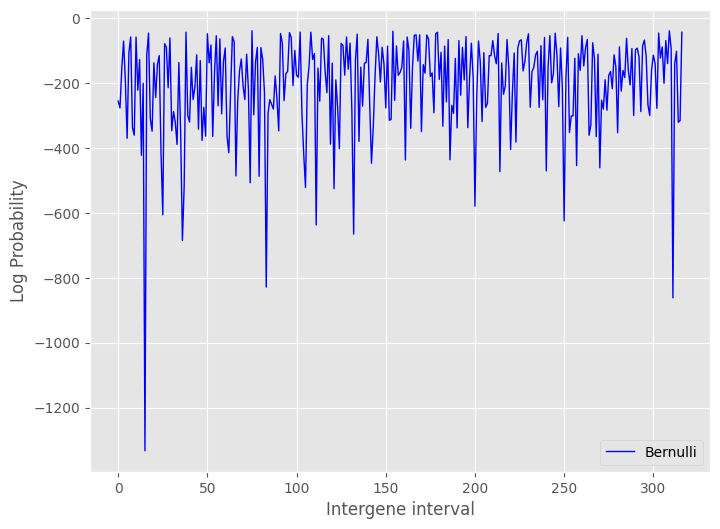

In [31]:
plot_lists([prob_bernulli], ['Bernulli'])

# markov 1


In [32]:
# считаем всевозможные пары нуклеотидов
markov1_dict = {}
for ind in range(len(train_join)-1):
  markov1_dict.setdefault(train_join[ind:ind+2], 0)
  markov1_dict[train_join[ind:ind+2]] += 1

In [33]:
# тут можно руками посчитать))
tx = markov1_dict['ta'] + markov1_dict['tc'] + markov1_dict['tg'] + markov1_dict['tt']
ax = markov1_dict['aa'] + markov1_dict['at'] + markov1_dict['ag'] + markov1_dict['ac']
gx = markov1_dict['gg'] + markov1_dict['gc'] + markov1_dict['ga'] + markov1_dict['gt']
cx = markov1_dict['cc'] + markov1_dict['ct'] + markov1_dict['ca'] + markov1_dict['cg']

In [34]:
markov1_dict

{'gg': 2282,
 'gc': 2591,
 'cg': 2351,
 'gt': 2083,
 'ta': 1392,
 'ag': 1958,
 'ga': 1856,
 'ac': 1931,
 'ca': 2026,
 'ct': 1990,
 'tg': 2221,
 'aa': 1988,
 'at': 1385,
 'tt': 2165,
 'tc': 1845,
 'cc': 2303}

In [35]:
# теперь считаем вероятности этих пар нуклеотидов и переводим их в лог шкалу
markov1_p = {}
for key, value in markov1_dict.items():
  markov1_p.setdefault(key, 0)
  if key[0] == 't':
    markov1_p[key] = np.log(value / tx)
  if key[0] == 'a':
    markov1_p[key] = np.log(value / ax)
  if key[0] == 'g':
    markov1_p[key] = np.log(value / gx)
  if key[0] == 'c':
    markov1_p[key] = np.log(value / cx)

In [42]:
len(markov1_p) # 16 параметров

16

In [37]:
# считаем правдоподобие для каждого межгенного промежутка в валидации:
prob_markov1 = [0] * len(valid_list)

for intergene in range(len(valid_list)):
  for couple in range(len(valid_list[intergene])-1):
     prob_markov1[intergene] += markov1_p[valid_list[intergene][couple:couple+2]]

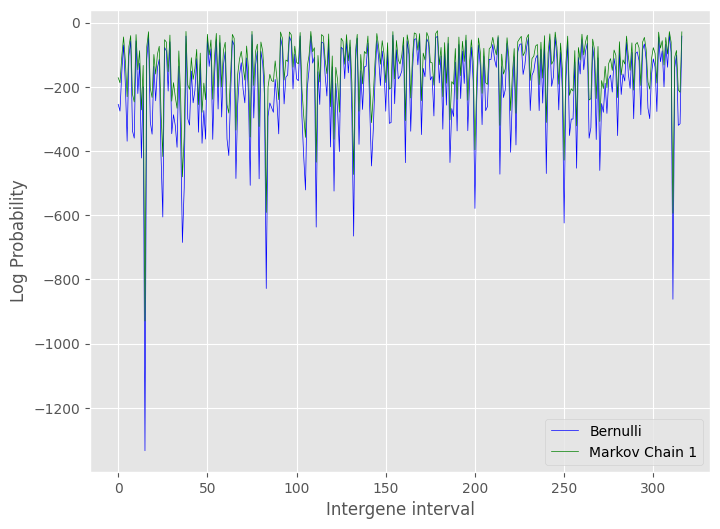

In [38]:
plot_lists([prob_bernulli, prob_markov1], ['Bernulli', 'Markov Chain 1'], lw=0.5)

# markov 2

In [39]:
# теперь ищем всевозможные тройки нуклеотидов
markov2_dict = {}
for ind in range(len(train_join)-2):
  markov2_dict.setdefault(train_join[ind:ind+3], 0)
  markov2_dict[train_join[ind:ind+3]] += 1

In [41]:
len(markov2_dict) # 64 параметра

64

In [43]:
# Нам нужны всевозможные пары нуклеотидов, для этого легче использовать itertools
import itertools

letters = 'atgc'

# Генерируем все возможные комбинации двух букв
combinations = [''.join(pair) for pair in itertools.product(letters, repeat=2)]

# Создаем словарь с пустыми значениями для каждой комбинации
markov2_supplementary = {combination+'x': 0 for combination in combinations} # это будут наши всевозможные пары + третий любой нуклеотид

# Выводим словарь
print(markov2_supplementary)

{'aax': 0, 'atx': 0, 'agx': 0, 'acx': 0, 'tax': 0, 'ttx': 0, 'tgx': 0, 'tcx': 0, 'gax': 0, 'gtx': 0, 'ggx': 0, 'gcx': 0, 'cax': 0, 'ctx': 0, 'cgx': 0, 'ccx': 0}


In [44]:
# считаем сколько их
for key, value in markov2_supplementary.items():
  for k, v in markov2_dict.items():
    if key[:2] in k:
      markov2_supplementary[key] += v

In [45]:
markov2_supplementary

{'aax': 3221,
 'atx': 2770,
 'agx': 3916,
 'acx': 3862,
 'tax': 2784,
 'ttx': 3533,
 'tgx': 4442,
 'tcx': 3690,
 'gax': 3712,
 'gtx': 4166,
 'ggx': 3894,
 'gcx': 5182,
 'cax': 4052,
 'ctx': 3980,
 'cgx': 4702,
 'ccx': 3867}

In [46]:
# теперь считаем вероятности
markov2_p = {}
for k, v in markov2_dict.items():
  for key, value in markov2_supplementary.items():
    if k[:2] in key:
      markov2_p.setdefault(k, 0)
      markov2_p[k] = np.log(v/value)

In [47]:
prob_markov2 = [0] * len(valid_list)

for intergene in range(len(valid_list)):
  for triples in range(len(valid_list[intergene])-2):
     prob_markov2[intergene] += markov2_p[valid_list[intergene][triples:triples+3]]

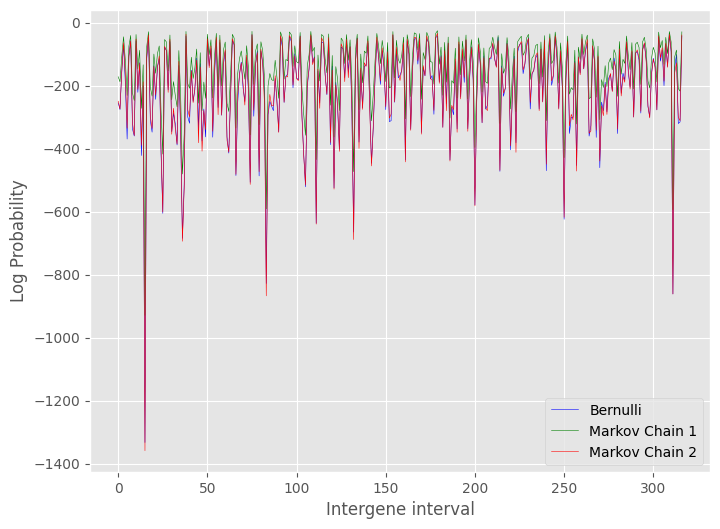

In [48]:
plot_lists([prob_bernulli, prob_markov1, prob_markov2], ['Bernulli', 'Markov Chain 1', 'Markov Chain 2'], lw=0.4)

# markov 3

In [49]:
# теперь четверки
markov3_dict = {}
for ind in range(len(train_join)-3):
  markov3_dict.setdefault(train_join[ind:ind+4], 0)
  markov3_dict[train_join[ind:ind+4]] += 1

In [50]:
assert 0 not in list(markov3_dict.values()), 'Rule Laplas is needed'

# четверки все есть, правило Лапласа не обязательно использовать

In [51]:
len(markov3_dict) # 256 параметров

256

In [52]:
import itertools

letters = 'atgc'

# Генерируем все возможные комбинации трех букв
combinations = [''.join(pair) for pair in itertools.product(letters, repeat=3)]

# Создаем словарь с пустыми значениями для каждой комбинации
markov3_supplementary = {combination+'x': 0 for combination in combinations}

# Выводим словарь
print(markov3_supplementary)

{'aaax': 0, 'aatx': 0, 'aagx': 0, 'aacx': 0, 'atax': 0, 'attx': 0, 'atgx': 0, 'atcx': 0, 'agax': 0, 'agtx': 0, 'aggx': 0, 'agcx': 0, 'acax': 0, 'actx': 0, 'acgx': 0, 'accx': 0, 'taax': 0, 'tatx': 0, 'tagx': 0, 'tacx': 0, 'ttax': 0, 'tttx': 0, 'ttgx': 0, 'ttcx': 0, 'tgax': 0, 'tgtx': 0, 'tggx': 0, 'tgcx': 0, 'tcax': 0, 'tctx': 0, 'tcgx': 0, 'tccx': 0, 'gaax': 0, 'gatx': 0, 'gagx': 0, 'gacx': 0, 'gtax': 0, 'gttx': 0, 'gtgx': 0, 'gtcx': 0, 'ggax': 0, 'ggtx': 0, 'gggx': 0, 'ggcx': 0, 'gcax': 0, 'gctx': 0, 'gcgx': 0, 'gccx': 0, 'caax': 0, 'catx': 0, 'cagx': 0, 'cacx': 0, 'ctax': 0, 'cttx': 0, 'ctgx': 0, 'ctcx': 0, 'cgax': 0, 'cgtx': 0, 'cggx': 0, 'cgcx': 0, 'ccax': 0, 'cctx': 0, 'ccgx': 0, 'cccx': 0}


In [53]:
for key, value in markov3_supplementary.items():
  for k, v in markov3_dict.items():
    if key[:3] in k:
      markov3_supplementary[key] += v

In [54]:
markov3_p = {}
for k, v in markov3_dict.items():
  for key, value in markov3_supplementary.items():
    if k[:3] in key:
      markov3_p.setdefault(k, 0)
      markov3_p[k] = np.log(v/value)

In [55]:
prob_markov3 = [0] * len(valid_list)

for intergene in range(len(valid_list)):
  for triples in range(len(valid_list[intergene])-3):
     prob_markov3[intergene] += markov3_p[valid_list[intergene][triples:triples+4]]

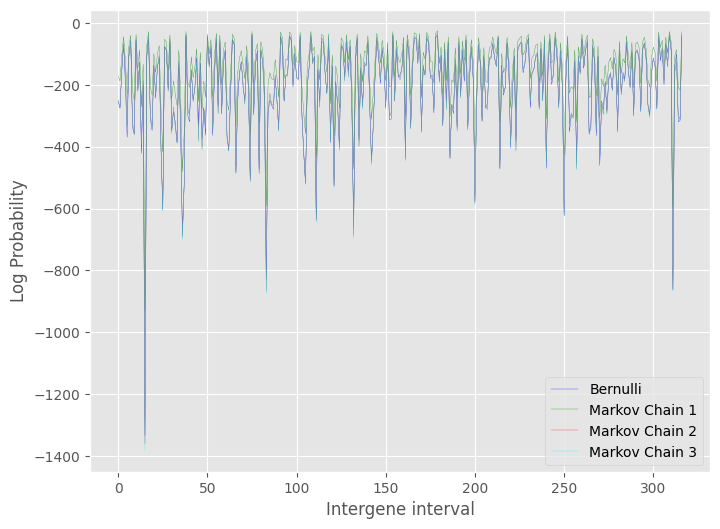

In [56]:
plot_lists([prob_bernulli, prob_markov1, prob_markov2, prob_markov3], ['Bernulli', 'Markov Chain 1', 'Markov Chain 2', 'Markov Chain 3'], lw=0.2)

# что имеем

In [57]:
bernulli_lh = sum(prob_bernulli)
markov1_lh = sum(prob_markov1)
markov2_lh = sum(prob_markov2)
markov3_lh = sum(prob_markov3)

print(f'Bernulli likelihood for valid data: {bernulli_lh}')
print(f'Markov chain 1 likelihood for valid data: {markov1_lh}')
print(f'Markov chain 2 likelihood for valid data: {markov2_lh}')
print(f'Markov chain 3 likelihood for valid data: {markov3_lh}')

Bernulli likelihood for valid data: -64998.29033934718
Markov chain 1 likelihood for valid data: -44813.7910832772
Markov chain 2 likelihood for valid data: -64493.55731208543
Markov chain 3 likelihood for valid data: -64770.92902551155


## Попарные сравнения: отношения правдоподобий

In [58]:
print(f'Relation Bernulli toward Markov 1 chain: [{bernulli_lh - markov1_lh}]')
print(f'Relation Bernulli toward Markov 2 chain: [{bernulli_lh - markov2_lh}]')
print(f'Relation Bernulli toward Markov 3 chain: [{bernulli_lh - markov3_lh}]')
print(f'Relation Markov 1 toward Markov 2 chain: [{markov1_lh - markov2_lh}]')
print(f'Relation Markov 1 toward Markov 3 chain: [{markov1_lh - markov3_lh}]')
print(f'Relation Markov 2 toward Markov 3 chain: [{markov2_lh - markov3_lh}]')

Relation Bernulli toward Markov 1 chain: [-20184.499256069976]
Relation Bernulli toward Markov 2 chain: [-504.73302726174734]
Relation Bernulli toward Markov 3 chain: [-227.36131383563043]
Relation Markov 1 toward Markov 2 chain: [19679.76622880823]
Relation Markov 1 toward Markov 3 chain: [19957.137942234345]
Relation Markov 2 toward Markov 3 chain: [277.3717134261169]


# Хуже всего показала себя модель Bernulli, чемпионом является марковская модель 1 типа, далее марковская модель 2 типа, на третьем месте марковская модель 3 типа

## (* – дополнительно) Оцените модели на обучающей выборке по AIC и BIC, сделайте выводы.

In [59]:
# считаем правдоподобия для бернулли для всего тренировочного сета:
bernulli_train_lh = 0

for nucleotide in train_join:
  if nucleotide == 'a':
    bernulli_train_lh += p_a
  if nucleotide == 't':
    bernulli_train_lh += p_t
  if nucleotide == 'g':
    bernulli_train_lh += p_g
  else:
    bernulli_train_lh += p_c

In [60]:
# считаем правдоподобия для марков1 для всего тренировочного сета:
markov1_train_lh = 0

for intergene in range(len(train_join)-1):
  markov1_train_lh += markov1_p[train_join[intergene:intergene+2]]

In [61]:
# считаем правдоподобия для марков2 для всего тренировочного сета:
markov2_train_lh = 0

for intergene in range(len(train_join)-2):
  markov2_train_lh += markov2_p[train_join[intergene:intergene+3]]

In [62]:
# считаем правдоподобия для марков3 для всего тренировочного сета:
markov3_train_lh = 0

for intergene in range(len(train_join)-3):
  markov3_train_lh += markov3_p[train_join[intergene:intergene+4]]

In [63]:
print(f'Bernulli likelihood for train data: {bernulli_train_lh}')
print(f'Markov chain 1 likelihood for train data: {markov1_train_lh}')
print(f'Markov chain 2 likelihood for train data: {markov2_train_lh}')
print(f'Markov chain 3 likelihood for train data: {markov3_train_lh}')

Bernulli likelihood for train data: -64370.269925665416
Markov chain 1 likelihood for train data: -44588.63041410215
Markov chain 2 likelihood for train data: -64715.78262564774
Markov chain 3 likelihood for train data: -65498.34783637086


## Формула AIC = 2k - 2ln(L)
## Формула BIC = ln(n) * k - 2ln(L)

где k - количество параметров в модели, а ln(L) - логарифм функции правдоподобия модели, n - количество наблюдений в выборке

In [64]:
aic_bernulli = (2 * 4) - (2 * bernulli_train_lh)
aic_markov1 = (2 * 16) - (2 * markov1_train_lh)
aic_markov2 = (2 * 64) - (2 * markov2_train_lh)
aic_markov3 = (2 * 256) - (2 * markov3_train_lh)

In [65]:
print(f'Bernulli AIC for train data: {aic_bernulli}')
print(f'Markov chain 1 AIC for train data: {aic_markov1}')
print(f'Markov chain 2 AIC for train data: {aic_markov2}')
print(f'Markov chain 3 AIC for train data: {aic_markov3}')

Bernulli AIC for train data: 128748.53985133083
Markov chain 1 AIC for train data: 89209.2608282043
Markov chain 2 AIC for train data: 129559.56525129548
Markov chain 3 AIC for train data: 131508.6956727417


# Чем ниже AIC тем лучше модель описывает данные. В нашем случае Марковская модель 1 типа лучше всего описывает тренировочные данные, остальные 3 примерно одинаково хуже

In [66]:
log_size = np.log(len(train_join))
bic_bernulli = (log_size * 4) - (2 * bernulli_train_lh)
bic_markov1 = (log_size * 16) - (2 * markov1_train_lh)
bic_markov2 = (log_size * 64) - (2 * markov2_train_lh)
bic_markov3 = (log_size * 256) - (2 * markov3_train_lh)

In [67]:
print(f'Bernulli BIC for train data: {bic_bernulli}')
print(f'Markov chain 1 BIC for train data: {bic_markov1}')
print(f'Markov chain 2 BIC for train data: {bic_markov2}')
print(f'Markov chain 3 BIC for train data: {bic_markov3}')

Bernulli BIC for train data: 128782.07955356846
Markov chain 1 BIC for train data: 89343.41963715482
Markov chain 2 BIC for train data: 130096.20048709757
Markov chain 3 BIC for train data: 133655.23661595004


# Результаты и выводы те же

(* – дополнительно) Проанализируйте модели на предмет устойчивости к переходу к комплементарным последовательностям (с биологической точки зрения модели должны остаться примерно теми же)

In [68]:
# сделаем комплиментарную валидационную выборку
reverse_valid_list = [[] for _ in range(len(valid_list))]
reverse_valid_list
for intergene in range(len(valid_list)):
  for nucleotide in valid_list[intergene]:
    if nucleotide == 'a':
      reverse_valid_list[intergene].append('t')
    if nucleotide == 't':
      reverse_valid_list[intergene].append('a')
    if nucleotide == 'g':
      reverse_valid_list[intergene].append('c')
    if nucleotide == 'c':
      reverse_valid_list[intergene].append('g')

In [69]:
for intergene in range(len(reverse_valid_list)):
  reverse_valid_list[intergene] = ''.join(reverse_valid_list[intergene])

In [70]:
# сравним
print(reverse_valid_list[0])
print(valid_list[0])

aaaacgcctaccctaagctgcctagacaagtttcaggtatcctgacgccaaaaagaacgcacgtcggatacgtgctgacacagagaggaacttgcgtcataccgaaacgcaatcttacgggcggga
ttttgcggatgggattcgacggatctgttcaaagtccataggactgcggtttttcttgcgtgcagcctatgcacgactgtgtctctccttgaacgcagtatggctttgcgttagaatgcccgccct


# Считаем вероятности

In [71]:
# считаем правдоподобие для каждого межгенного промежутка в валидации:
prob_bernulli_rev = [0] * len(reverse_valid_list)

for intergene in range(len(reverse_valid_list)):
  for nucleotide in reverse_valid_list[intergene]:
    if nucleotide == 'a':
      prob_bernulli_rev[intergene] += p_a
    if nucleotide == 't':
      prob_bernulli_rev[intergene] += p_t
    if nucleotide == 'g':
      prob_bernulli_rev[intergene] += p_g
    else:
      prob_bernulli_rev[intergene] += p_c

In [72]:
# считаем правдоподобие для каждого межгенного промежутка в валидации:
prob_markov1_rev = [0] * len(reverse_valid_list)

for intergene in range(len(reverse_valid_list)):
  for couple in range(len(reverse_valid_list[intergene])-1):
     prob_markov1_rev[intergene] += markov1_p[reverse_valid_list[intergene][couple:couple+2]]

In [73]:
prob_markov2_rev = [0] * len(reverse_valid_list)

for intergene in range(len(reverse_valid_list)):
  for triples in range(len(reverse_valid_list[intergene])-2):
     prob_markov2_rev[intergene] += markov2_p[reverse_valid_list[intergene][triples:triples+3]]

In [74]:
prob_markov3_rev = [0] * len(reverse_valid_list)

for intergene in range(len(reverse_valid_list)):
  for triples in range(len(reverse_valid_list[intergene])-3):
     prob_markov3_rev[intergene] += markov3_p[reverse_valid_list[intergene][triples:triples+4]]

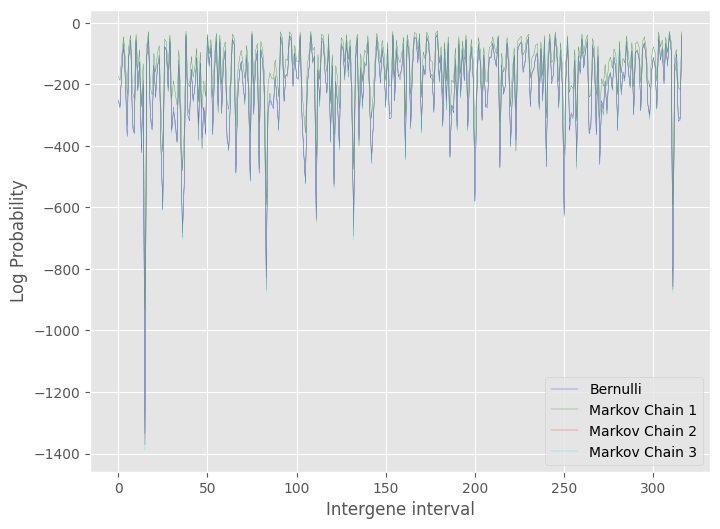

In [75]:
plot_lists([prob_bernulli_rev, prob_markov1_rev, prob_markov2_rev, prob_markov3_rev], ['Bernulli', 'Markov Chain 1', 'Markov Chain 2', 'Markov Chain 3'], lw=0.2)

In [76]:
bernulli_lh_rev = sum(prob_bernulli_rev)
markov1_lh_rev = sum(prob_markov1_rev)
markov2_lh_rev = sum(prob_markov2_rev)
markov3_lh_rev = sum(prob_markov3_rev)

print(f'Bernulli likelihood for valid data: {bernulli_lh} and for complementary valid data: {bernulli_lh_rev}')
print(f'Markov chain 1 likelihood for valid data: {markov1_lh} and for complementary valid data: {markov1_lh_rev}')
print(f'Markov chain 2 likelihood for valid data: {markov2_lh} and for complementary valid data: {markov2_lh_rev}')
print(f'Markov chain 3 likelihood for valid data: {markov3_lh} and for complementary valid data: {markov3_lh_rev}')

Bernulli likelihood for valid data: -64998.29033934718 and for complementary valid data: -65007.098466293304
Markov chain 1 likelihood for valid data: -44813.7910832772 and for complementary valid data: -44895.740229533
Markov chain 2 likelihood for valid data: -64493.55731208543 and for complementary valid data: -64815.57263775043
Markov chain 3 likelihood for valid data: -64770.92902551155 and for complementary valid data: -65140.17956766932


# получилось одно и тоже

(* – дополнительно) Проанализируйте не только суммарные логарифмы отношений правдоподобия, но и их распределения: часто ли конкретная последовательность описывается лучше не той моделью, которая лучше в среднем?

# Так ну я уже всю дорогу рисовал распределения логарифмов правдоподобий последовательностей к счастью

Давайте подробнее посмотрим например на лучшую модель и худшую, в нашем случае это марковская модель 1 типа и бернулли

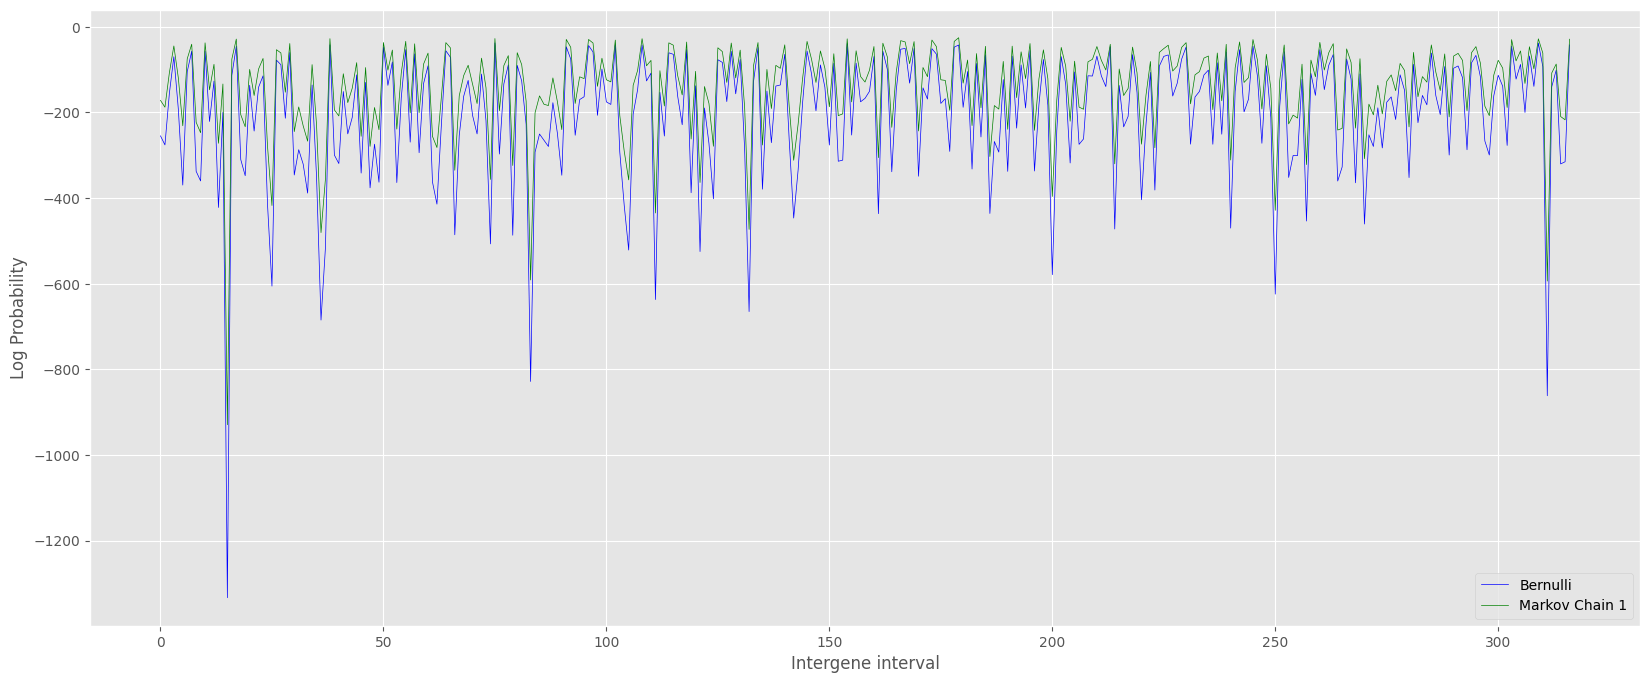

In [77]:
plot_lists([prob_bernulli, prob_markov1], ['Bernulli', 'Markov Chain 1'], lw=0.5, figsize=(20,8))

In [78]:
for intergene in range(len(prob_bernulli)):
  if prob_bernulli[intergene] > prob_markov1[intergene]:
    print(intergene)

## для этой пары, абсолютно все межгенные промежутки описываются лучше с помощью марковской модели 1 типа

## Теперь сравним Марковскую модель 1 типа и 2 типа

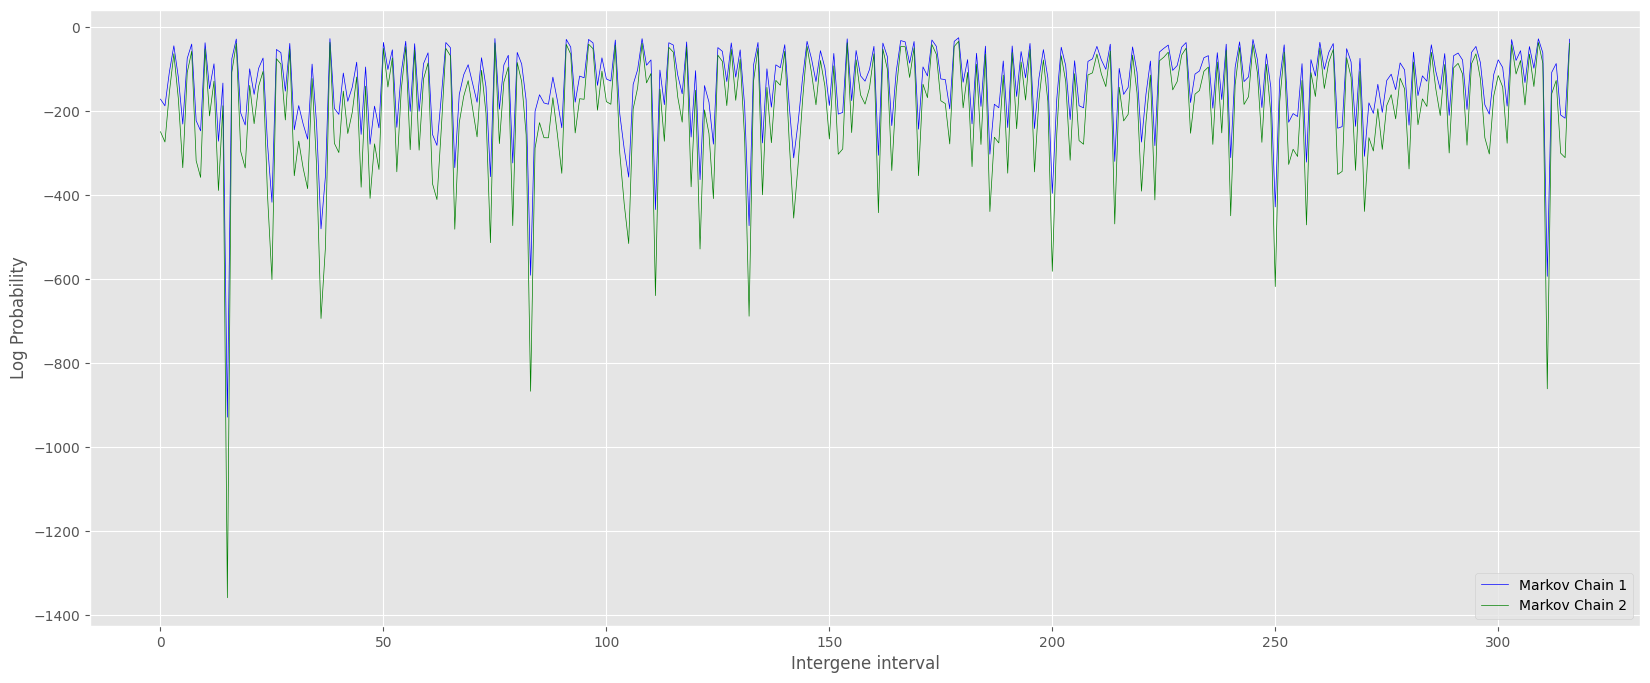

In [79]:
plot_lists([prob_markov1, prob_markov2], ['Markov Chain 1', 'Markov Chain 2'], lw=0.5, figsize=(20,8))

In [80]:
for intergene in range(len(prob_bernulli)):
  if prob_markov2[intergene] > prob_markov1[intergene]:
    print(intergene)

## тоже самое

## Теперь сравним Марковскую модель 1 типа и 3 типа

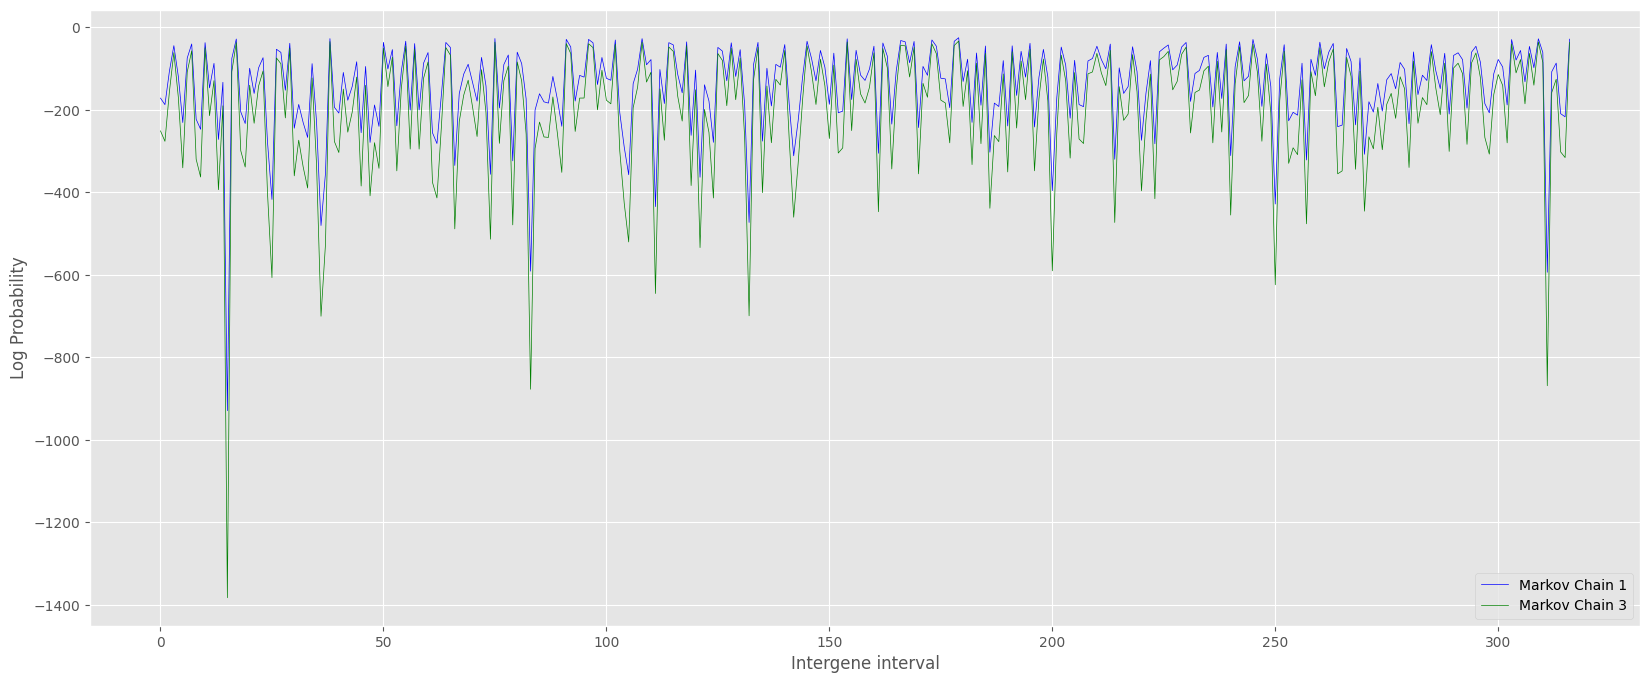

In [81]:
plot_lists([prob_markov1, prob_markov3], ['Markov Chain 1', 'Markov Chain 3'], lw=0.5, figsize=(20,8))

In [82]:
for intergene in range(len(prob_bernulli)):
  if prob_markov3[intergene] > prob_markov1[intergene]:
    print(intergene)

## тоже самое
## Марковская модель 1 типа описываем все межгенные промежутки лучше всех!
## Теперь сравним Бернулли с остальными

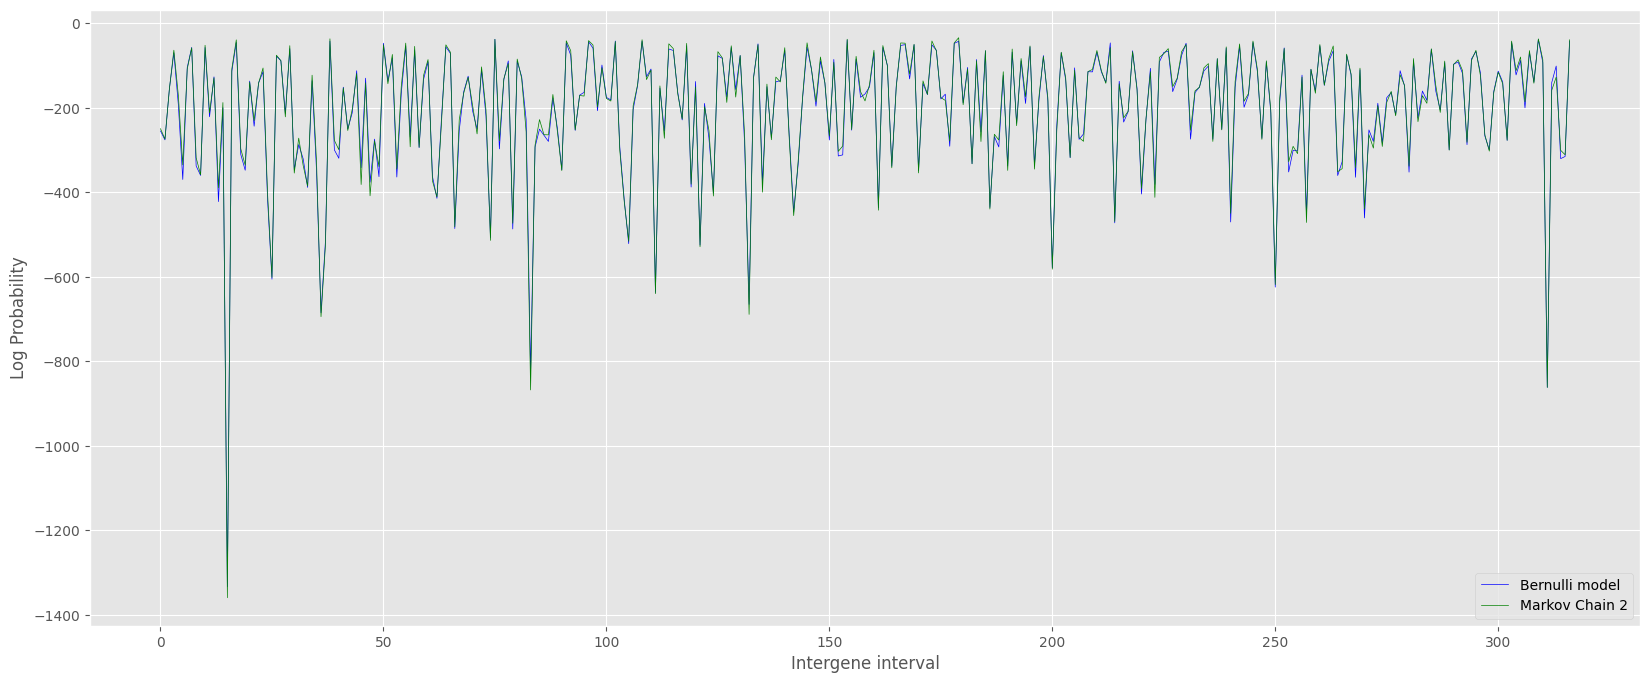

In [83]:
plot_lists([prob_bernulli, prob_markov2], ['Bernulli model', 'Markov Chain 2'], lw=0.5, figsize=(20,8))

# Уже невооруженым взглядом видно что есть участки где бернулли лучше описало межгенный промежуток чем марковская модель 2 типа

In [84]:
intergenes_where_bernulli_beat_markov_2 = []
for intergene in range(len(prob_bernulli)):
  if prob_bernulli[intergene] > prob_markov2[intergene]:
    intergenes_where_bernulli_beat_markov_2.append(intergene)

In [85]:
print(f'In {len(intergenes_where_bernulli_beat_markov_2)} cases Bernulli model was better then Markov 2 model. Entire cases: {len(prob_bernulli)}')

In 128 cases Bernulli model was better then Markov 2 model. Entire cases: 317


# Сравним бернулли и маркоскую модель 3 типа

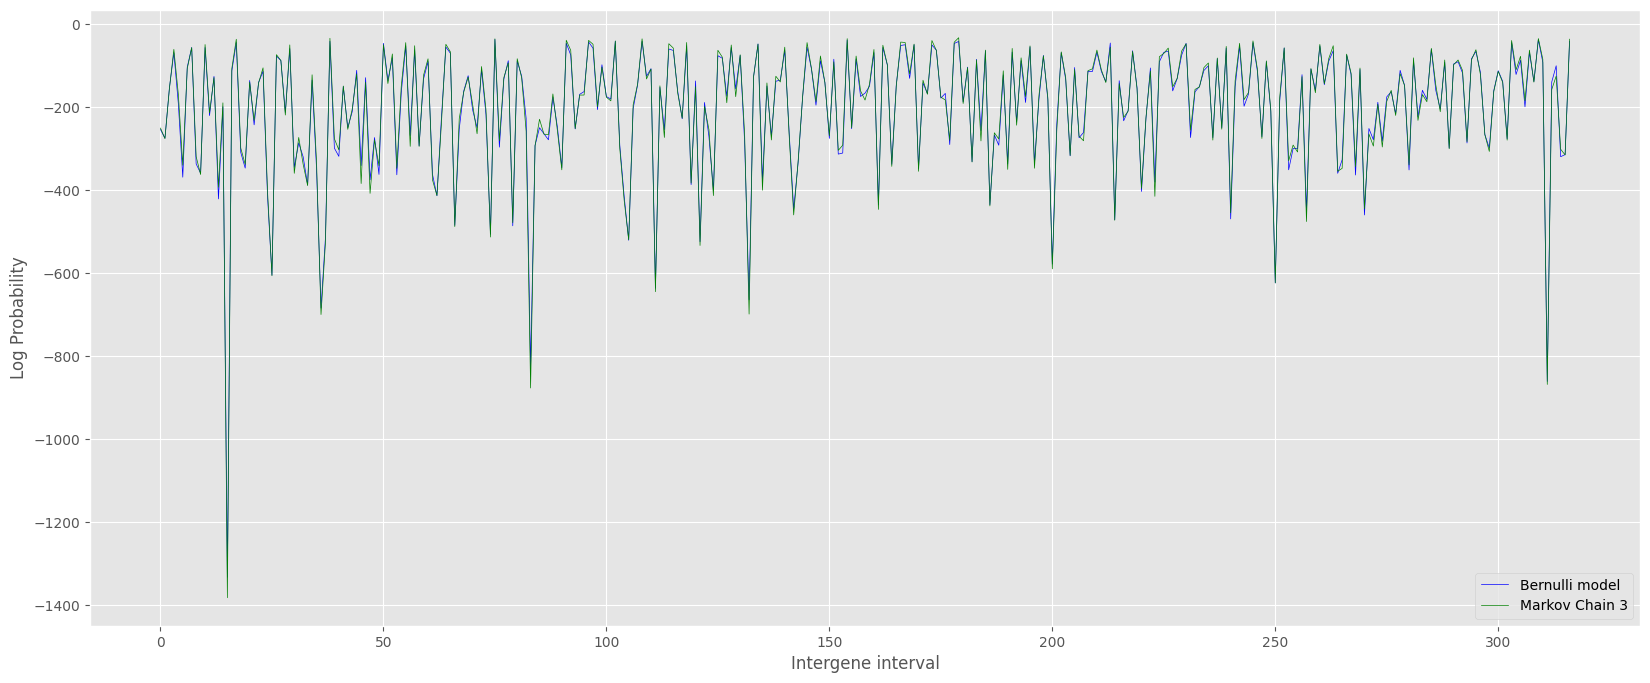

In [86]:
plot_lists([prob_bernulli, prob_markov3], ['Bernulli model', 'Markov Chain 3'], lw=0.5, figsize=(20,8))

In [87]:
intergenes_where_bernulli_beat_markov_3 = []
for intergene in range(len(prob_bernulli)):
  if prob_bernulli[intergene] > prob_markov3[intergene]:
    intergenes_where_bernulli_beat_markov_3.append(intergene)

In [88]:
print(f'In {len(intergenes_where_bernulli_beat_markov_3)} cases Bernulli model was better then Markov 3 model. Entire cases: {len(prob_bernulli)}')

In 138 cases Bernulli model was better then Markov 3 model. Entire cases: 317


# И последнее : сравним марковскую модель 2 и 3 типов

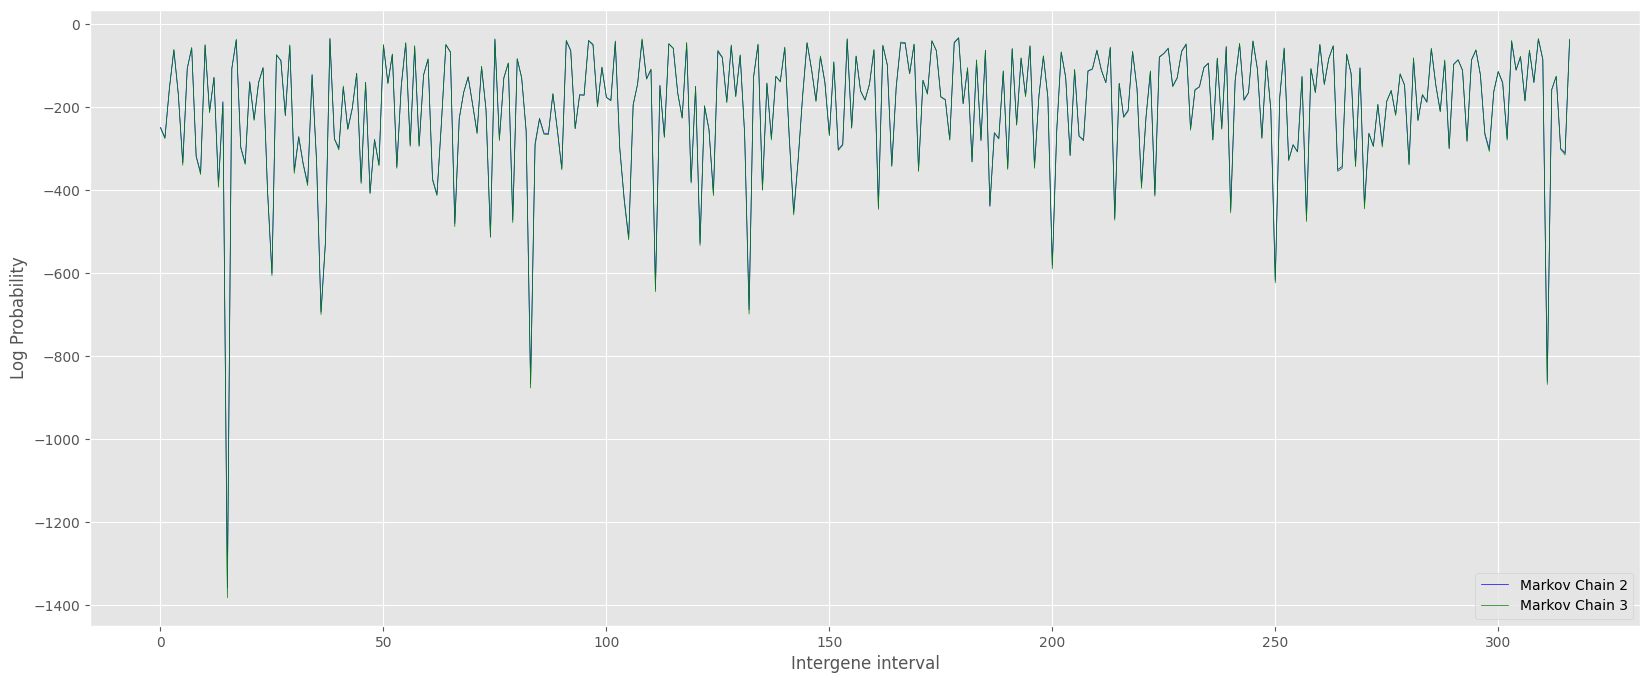

In [89]:
plot_lists([prob_markov2, prob_markov3], ['Markov Chain 2', 'Markov Chain 3'], lw=0.5, figsize=(20,8))

#  Ощущение что они идентичные

In [90]:
intergenes_where_markov_2_beat_markov_3 = []
for intergene in range(len(prob_bernulli)):
  if prob_markov2[intergene] > prob_markov3[intergene]:
    intergenes_where_markov_2_beat_markov_3.append(intergene)

In [91]:
print(f'In {len(intergenes_where_markov_2_beat_markov_3)} cases Markov 2 model was better then Markov 3 model. Entire cases: {len(prob_bernulli)}')

In 171 cases Markov 2 model was better then Markov 3 model. Entire cases: 317


# проверим на всякий случай, может быть есть межгенные промежутки где равны правдоподобия (это будет значить что где то ошибка)

In [92]:
intergenes_where_markov_2_equal_markov_3 = []
for intergene in range(len(prob_bernulli)):
  if prob_markov2[intergene] == prob_markov3[intergene]:
    intergenes_where_markov_2_equal_markov_3.append(intergene)

In [93]:
intergenes_where_markov_2_equal_markov_3

[]